# LDATA2010 Exercise Session - Clustering

Clustering aims at automatically discovering groups of similar samples among data sets. This statement briefly introduces different clustering algorithms. The exercises can be realized using the software of your preference (Python, R, Matlab, etc.). The dataset we will use in this session is based on [transcriptomics data](https://en.wikipedia.org/wiki/Transcriptomics_technologies). As you can see when importing the dataset, the first columns are 300 different gene expressions, and the last column ("cell_type") contains an identifier for the type of the cell.

Each row represents the analysis of *one* cell, and each of the "gene" columns contains (in layman's terms and not wholly accurately) the expression of the gene at one location in the sequence.

## Tools and libraries

To help you implement and test the various clustering algorithms presented during this session, we provide a (non-exhaustive) list of libraries that can be useful. Don't hesitate to look at the documentation for each of these libraries, to get a feel of what they can offer you.

In particular, the `pca_decomposition` function implements PCA, a dimensionality reduction method you will see more thoroughly during the course. We will use it now for 2D visualization, because although we might want to test clustering algorithms in 2D, they start being especially useful with high dimensional data.

> Is it better to first reduce the dimensionality of the dataset and then do clustering or first do clustering and then visualize in a lower dimension ?

In [1]:
# Importing the data and nice libraries
import matplotlib.pyplot as plt # https://matplotlib.org/
import numpy as np # https://numpy.org/doc/1.26/user/index.html#user
import pandas as pd # https://pandas.pydata.org/
import seaborn as sns # https://seaborn.pydata.org/
from sklearn.decomposition import PCA # https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
from sklearn.preprocessing import StandardScaler # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from IPython.display import display, clear_output # https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html

def pca_decomposition(df, components=2):
    """Perform PCA on a dataset.

    PCA is a dimensionality reduction method, which we use to go from 300 dimensions down to 2.
    """
    pca = PCA(n_components=components)
    df2 = pca.fit_transform(df)
    return df2, pca

## Dataset
> **Exercise 1**
> Create a scatter plot of X after PCA in a 2-D space. How many clusters do you intuitively observe ? Do you think these clusters are present in the 300-dimension space ?

In [2]:
dataframe = pd.read_csv("https://gist.githubusercontent.com/victorjoos/34b43873616f253451af610ca8460ddf/raw/ad9b89f72c6c67318e08de13871c34d56fbae259/transcriptomics_data.csv")
y = dataframe["cell_type"]
X = dataframe[[col for col in dataframe.columns if col.startswith("gene_")]].to_numpy() # Only keep gene expressions

X_pca, pca = pca_decomposition(X) # Compute PCA DR

print("dataset shape before PCA:", X.shape)
print("dataset shape after PCA:", X_pca.shape)

dataset shape before PCA: (4765, 300)
dataset shape after PCA: (4765, 2)


In [ ]:
# Your code here !

## K-means

The K-means algorithm may be summarized as follows : given,
 - a set $ D = \{x_1, ..., x_N\} $ of N data points with dimension H,
 - a distance function d,
 - a number K of clusters,

it defines a set $ C = {c_1, ..., c_K}$  of K centroids with dimension H. After initializing the centroids according to some heuristic (e.g. randomly in the data space, randomly in D, etc.), the centroid coordinates are updated according to the following scheme:

 1. For each $ i \in \{1, ..., K\} $, compute $ D_i = \{x_j \in D | i = \mathrm{argmin}_{l\in{1, ..., K}} d(c_l, x_j)\} $
 2. For each $ i \in \{1, ..., K\} $, set $c_i \leftarrow \frac{1}{ | D_i | } \sum_{x\in D_i}{x}$

Computing steps 1 and 2 corresponds to performing *one* iteration. Iterations are repeated until convergence of the centroids or after a maximum number has been reached. The clusters are then defined as the sets $D_i$ for $i\in\{1, ..., K\}$

> **Exercise 2** Implement the K-means algorithm with Euclidian distance and apply it to X with K = 3 clusters and with the centroids chosen at random from the dataset. After each iteration, show the new clusters and centroids. How many iterations are needed before convergence ? Does the result seem intuitive ?
>
> What happens when you change K ?
>
> Do all the cells with the same cell type go in the same cluster ? How would you visualize this ?
>
> Does K-Means work even when the initial centroids are all in the same cluster ?
>
> Do you get the same result when doing the clustering on `X_pca` ?

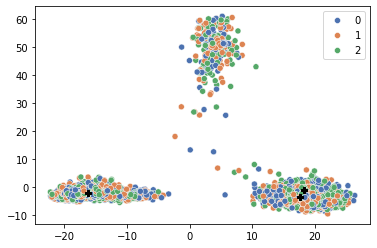

In [4]:
def kmeans_iteration(X, centroids):
    # 1. compute the distance to the closest centroid
    clusters = np.random.randint(len(centroids), size=len(X)).astype(int) # CHANGME : The ID of the closest centroid for each element in the dataset
    # 2. update the centroids
    centroids = X[:3] # CHANGME : the updated centroids
    return clusters, centroids

max_iter = 10 # CHANGME ?
K = 3 # CHANGME ?
centroids = X[:3] # CHANGME : Pick initial centroids randomly

## Visualization

fig, ax = plt.subplots(1)
old_centroids = np.zeros_like(centroids)
i = 0
while not np.allclose(centroids, old_centroids) and i<max_iter: # Test if has converged
    i += 1
    old_centroids = centroids
    clusters, centroids = kmeans_iteration(X, centroids)
    ax.cla()
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters, palette="deep", ax=ax)
    C_pca = pca.transform(centroids)
    ax.scatter(C_pca[:,0], C_pca[:,1], c="black", marker="P")
    display(fig)
    clear_output(wait=True)

## Nearest neighbor clustering
Given a set $ D = \{x_1, ..., x_N\}$ of $N$ data points, a distance function $d$ and a threshold $t$, nearest neighbor clustering defines clusters in $D$ in the following way :

 - Define $C_1 = \{x_1\}, C= \{C_1\}$ and $K = 1$;
 - For $i = 2,..., N$,
  1. Compute $j = \mathrm{argmin}_{l\in\{1,...,i-1\}}d(x_l,x_i)$
  2. If $d(x_j, x_i) \ge t$ set $K\leftarrow K + 1$, define $C_K = {x_i}$ and set $C \leftarrow C \cup \{C_K\}$
  3. Otherwise, identify $k\in {1, ..., K}$ such that $x_j \in C_k$ and set $C_k \leftarrow C_k \cup \{x_i\}$

Whereas K-means needs the user to specify the desired number K of clusters, nearest neighbor clustering instead requires to define a threshold $t$ for the minimum distance between two clusters.

> **Exercise 3** Implement nearest neighor clustering with the Euclidian distance and apply it to X, using a threshold t = 5. Do you obtain the same result as when using K-means ? Does the order of the dataset matter ?
>
> How does the algorithm change when using a different threshold ? What is the threshold range where you get 3 clusters ?

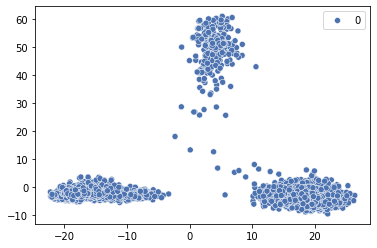

In [5]:
def nneighbor_iteration(X, i, clusters, threshold):
    # 1. compute the index of the closest neighbor
    j = i-1 # CHANGME
    # 2. update the clusters
    clusters[i] = clusters[j] # CHANGME : take care of the threshold
    return clusters

threshold = 5 # CHANGME ?
clusters = np.ones(len(X), dtype=int) * -1 # init all nodes to to a negative index ("unassigned")
clusters[0] = 0 # create the first cluster

##  Visualization
display_every_n = 100 # CHANGME ?

fig, ax = plt.subplots(1)

for i in range(1, len(X)):
    clusters = nneighbor_iteration(X, i, clusters, threshold)
    if (i % display_every_n) == 0 or i == len(X)-1:
      ax.cla()
      sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters[:], palette="deep", ax=ax)
      # Alternative, to display only assigned nodes :
      # sns.scatterplot(x=X_pca[:i,0], y=X_pca[:i,1], hue=clusters[:i], palette="deep", ax=ax)
      display(fig)
      clear_output(wait=True)